# Idealista API

Access is free to a maximum of 100 req/month and it’s limited by 1 req/sec.

In [6]:
import httpx
import base64
import os

# %% Request auth token

API_KEY = os.environ.get('API_KEY')
SECRET = os.environ.get('API_SECRET')

message = API_KEY + ":" + SECRET
auth = "Basic " + base64.b64encode(message.encode("ascii")).decode("ascii")

headers_dic = {"Authorization": auth,
               "Content-Type": "application/x-www-form-urlencoded;charset=UTF-8"}

params_dic = {"grant_type": "client_credentials",
              "scope": "read"}

r = httpx.post("https://api.idealista.com/oauth/token",
                  headers=headers_dic,
                  params=params_dic)
# %%

In [7]:
from typing import Final

token = r.json()
access_token = token['access_token']

BASE_URL: Final[str] = "https://api.idealista.com/3.5/es/search"
headers = {'Authorization': 'Bearer ' + access_token}

lat: float = 40.488810
lon: float = -3.365879
distance: float = 5e3

params = {
    'center': f'{lat},{lon}',
    'country': 'es',
    'maxItems': '100',
    'numPage': '1',
    'distance': distance,
    'propertyType': 'homes',
    'maxPrice': 400e3,
    'operation': 'sale',  # rent
}

response = httpx.post(BASE_URL, headers=headers, params=params)


In [ ]:
from tqdm import tqdm

data = response.json()

pages = [data]

if data['totalPages'] > 1:
    for i in tqdm(range(2, data['totalPages'] + 1)):
        params['numPage'] = i
        response = httpx.post(BASE_URL, headers=headers, params=params)

        pages.append(response.json())

100%|██████████| 6/6 [00:03<00:00,  1.75it/s]


In [46]:
import json

with open('data/alcala.json', 'w') as f:
    json.dump([el for item in pages for el in item["elementList"]], f)

## Exploratory Data Analysis

In [56]:
import pandas as pd

df = pd.json_normalize([el for item in pages for el in item["elementList"]])

(0.0, 599200.0)

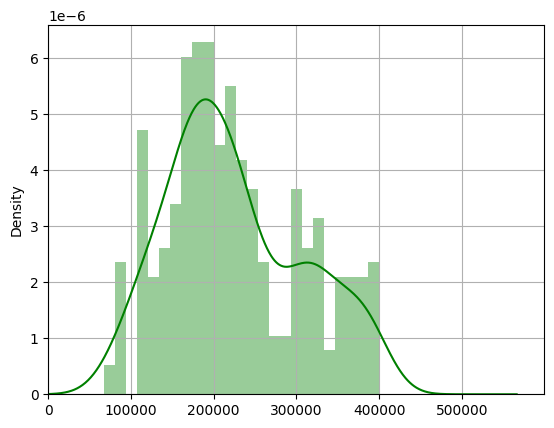

In [64]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
df['price'].plot.density(ax=ax, color='g')
df['price'].hist(ax=ax, bins=25, density=True, color='g', alpha=.4)
ax.set_xlim([0, None])

<Axes: >

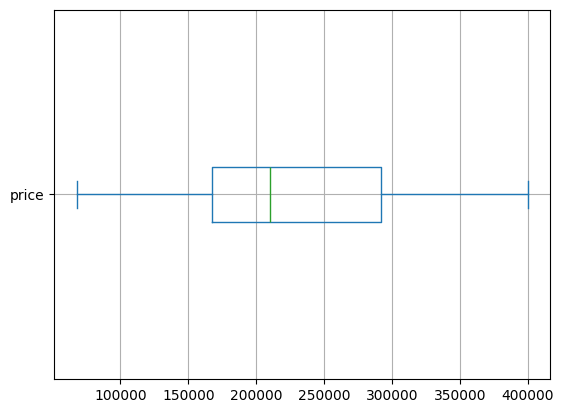

In [62]:
df['price'].plot.box(vert=False, grid=True)

<Axes: xlabel='size', ylabel='price'>

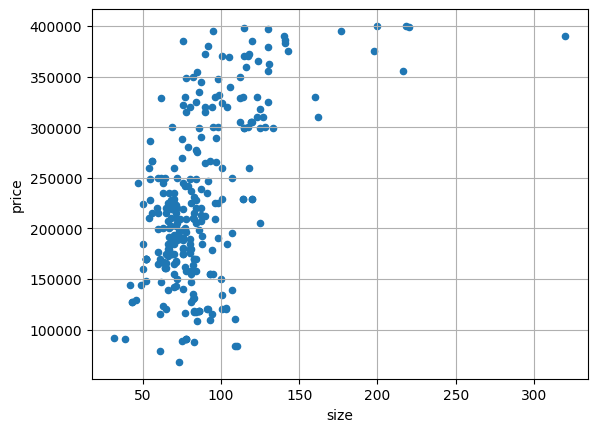

In [65]:
df.plot.scatter(x='size', y='price', grid=True)